In [3]:
import resource

In [4]:
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

50420

In [ ]:
fla

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [22]:
# list(ls.filter(regex=("DATE")))

['VINTAGE_DATE',
 'FIRST_TRANSACTION_DATE',
 'FIRST_DEPOSIT_DATE',
 'LAST_TRANSACTION_DATE',
 'LAST_LOGIN_DATE']

In [1]:
ls

0807_fulldata_pipeline_pca_kmean.ipynb  lender_main.py
EDA_0803.ipynb                          lender_pipeline.py
EDA_0807.ipynb                          lender_pipeline.pyc
EDA_0807_pipeline.ipynb                 loans_lenders.csv
lender_dataset.csv                      __pycache__/
lender_dataset_sampled.csv              untitled.txt


In [2]:
ls = pd.read_csv('lender_dataset_sampled.csv')

In [4]:
ls

,FUND_ACCOUNT_ID,LOGIN_ID,VINTAGE_YEAR,VINTAGE_MONTH,VINTAGE_DATE,FIRST_TRANSACTION_DATE,FIRST_DEPOSIT_DATE,LAST_TRANSACTION_DATE,LAST_LOGIN_DATE,ACTIVE_LIFETIME_MONTHS,...,NUM_BUNDLE_CONFLICT_ZONE_LOANS,NUM_BUNDLE_JOB_CREATION_SME_LOANS,NUM_BUNDLE_GROWING_BUSINESSES_LOANS,NUM_BUNDLE_HEALTH_LOANS,NUM_BUNDLE_DISASTER_RECOVERY_LOANS,NUM_BUNDLE_INNOVATIVE_LOANS,NUM_BUNDLE_REFUGEE_LOANS,NUM_BUNDLE_SOCIAL_ENTERPRISE_LOANS,NUM_BUNDLE_CLEAN_ENERGY_LOANS,NUM_BUNDLE_SOLAR_LOANS
0,1152,1152,2006,200601,2006-01-01 00:00:00.000 -0800,2006-12-28 00:00:00.000 -0800,2006-12-28 00:00:00.000 -0800,2018-05-03 00:00:00.000 -0700,2018-05-03 00:00:00.000 -0700,137,...,0,0,0,0,0,2,1,0,2,0
1,17575,17575,2006,200612,2006-12-13 00:00:00.000 -0800,2006-12-13 00:00:00.000 -0800,2006-12-13 00:00:00.000 -0800,2018-03-08 00:00:00.000 -0800,2018-03-08 00:00:00.000 -0800,135,...,0,0,0,0,0,0,0,0,0,0
2,20542,20542,2006,200612,2006-12-21 00:00:00.000 -0800,2006-12-21 00:00:00.000 -0800,2006-12-21 00:00:00.000 -0800,2017-07-22 00:00:00.000 -0700,2017-07-31 00:00:00.000 -0700,127,...,3,1,1,0,0,2,0,0,0,0
3,13960,13960,2006,200611,2006-11-24 00:00:00.000 -0800,2008-02-06 00:00:00.000 -0800,2008-02-06 00:00:00.000 -0800,2016-10-10 00:00:00.000 -0700,2016-10-10 00:00:00.000 -0700,104,...,9,0,0,0,0,0,0,1,1,1
4,14929,14929,2006,200612,2006-12-01 00:00:00.000 -0800,2006-12-01 00:00:00.000 -0800,2006-12-01 00:00:00.000 -0800,2010-08-23 00:00:00.000 -0700,2016-04-29 00:00:00.000 -0700,44,...,0,0,0,0,0,0,0,0,0,0
5,14043,14043,2006,200611,2006-11-25 00:00:00.000 -0800,2006-11-25 00:00:00.000 -0800,2006-11-25 00:00:00.000 -0800,2018-03-27 00:00:00.000 -0700,2018-03-27 00:00:00.000 -0700,136,...,1,0,0,0,0,0,1,0,0,0
6,24059,24059,2006,200612,2006-12-27 00:00:00.000 -0800,2006-12-27 00:00:00.000 -0800,2008-06-27 00:00:00.000 -0700,2016-12-26 00:00:00.000 -0800,2011-10-16 00:00:00.000 -0700,120,...,0,0,0,0,0,0,0,0,0,0
7,10009,10009,2006,200611,2006-11-08 00:00:00.000 -0800,2006-11-08 00:00:00.000 -0800,2006-11-08 00:00:00.000 -0800,2011-02-15 00:00:00.000 -0800,2017-05-31 00:00:00.000 -0700,51,...,0,0,0,0,0,0,0,0,0,0
8,12023,12023,2006,200611,2006-11-14 00:00:00.000 -0800,2006-11-14 00:00:00.000 -0800,2006-11-14 00:00:00.000 -0800,2007-06-13 00:00:00.000 -0700,2007-06-13 00:00:00.000 -0700,7,...,0,0,0,0,0,0,0,0,0,0
9,6753,6753,2006,200611,2006-11-04 00:00:00.000 -0800,2006-11-04 00:00:00.000 -0800,2006-11-04 00:00:00.000 -0800,2018-04-09 00:00:00.000 -0700,2018-04-09 00:00:00.000 -0700,137,...,2,2,1,0,0,0,2,1,0,0


## 1. Feature Engineering

### 1.1 data cleaning & formatting

In [3]:
from lender_pipeline import pipeline

In [4]:
X = pipeline(ls)

In [ ]:
ls.head().T

In [ ]:
ls = ls.replace({'no': 0, 'yes': 1})

In [ ]:
ls.IS_INACTIVE_CREDIT_DONOR = ls.IS_INACTIVE_CREDIT_DONOR.astype(int)

In [ ]:
def convert_datetime(df,col):
    df[col] = pd.to_datetime(df[col])

In [ ]:
# List of columns with "dates"
ls.filter(regex=("DATE")).columns

In [ ]:
for col in list(ls.filter(regex=("DATE")).columns):
    convert_datetime(ls,col)

### 1.3 create/convert new features 

#### 1.3.1 timestamp --> period

In [ ]:
today = ls['LAST_LOGIN_DATE'].max()

In [ ]:
today

In [ ]:
ls["last_login_today"] = ((ls['LAST_LOGIN_DATE'] - today) / -np.timedelta64(1, 'D')).astype(int)

In [ ]:
ls['last_transaction_today'] = ((ls['LAST_TRANSACTION_DATE'] - today) / -np.timedelta64(1, 'D')).astype(int)

In [ ]:
ls['first_transaction_period'] = ((ls['FIRST_TRANSACTION_DATE'] - ls['VINTAGE_DATE']) / np.timedelta64(1, 'D')).astype(int)

In [ ]:
ls.FIRST_DEPOSIT_DATE.isnull().sum() # ~half of the first_deposit_day is missing so we will not use it

In [ ]:
ls = ls.drop(['LAST_TRANSACTION_DATE','LAST_LOGIN_DATE','FIRST_TRANSACTION_DATE','VINTAGE_DATE','FIRST_DEPOSIT_DATE'],axis=1)

#### 1.3.2 donation rate

Create a new feature : donation rate.

In [ ]:
# replace purchase total 0 to 0.01 to avoid infinite number in division
ls.LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL = ls.LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL.replace({0:0.01})

In [ ]:
ls['lifetime_ave_tip_rate'] = (ls.LIFETIME_DONATION_TOTAL/ls.LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL)

### 1.5 cols to keep as features

In [ ]:
mini_cols = [
 'ACTIVE_LIFETIME_MONTHS',
 'ACCOUNT_AGE_MONTHS',
 'IS_CORPORATE_CAMPAIGN_USER',
 'IS_FREE_TRIAL_USER',
 'IS_INACTIVE_CREDIT_DONOR',
 'LIFETIME_DONATION_TOTAL',
 'LIFETIME_DEPOSIT_TOTAL',
 'LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL',
 'LIFETIME_PROXY_LOAN_PURCHASE_TOTAL',
 'LIFETIME_DEPOSIT_NUM',
 'LIFETIME_ACCOUNT_LOAN_PURCHASE_NUM',
 'LIFETIME_PROXY_LOAN_PURCHASE_NUM',
 'LIFETIME_DONATION_NUM',
 'CORE_LOAN_PURCHASE_NUM',
 'CORE_LOAN_PURCHASE_TOTAL',
 'DIRECT_LOAN_PURCHASE_NUM',
 'DIRECT_LOAN_PURCHASE_TOTAL',
 'FIRST_YEAR_DEPOSIT_TOTAL',
 'FIRST_YEAR_LOAN_PURCHASE_TOTAL',
 'FIRST_YEAR_DONATION_TOTAL',
 'FIRST_YEAR_EMAIL_REFERRAL_DONATION_TOTAL',
 'FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_TOTAL',
 'FIRST_DAY_DEPOSIT_TOTAL',
 'FIRST_DAY_LOAN_PURCHASE_TOTAL',
 'FIRST_DAY_DONATION_TOTAL',
 'FIRST_YEAR_DEPOSIT_OCCASION_NUM',
 'FIRST_YEAR_LOAN_PURCHASE_OCCASION_NUM',
 'FIRST_YEAR_DONATION_OCCASION_NUM',
 'FIRST_YEAR_EMAIL_REFERRAL_DONATION_OCCASION_NUM',
 'FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_OCCASION_NUM',
 'NUM_TEAM_MEMBERSHIPS',
 'NUM_TEAM_LOANS',
 'NUM_TEAM_MESSAGES',
 'NUM_LOAN_COMMENTS',
 'NUM_JOURNAL_COMMENTS',
 'NUM_STATEMENT_COMMENTS',
 'NUM_DISTINCT_COUNTRIES_LENT_TO','last_login_today',
 'last_transaction_today',
 'first_transaction_period','lifetime_ave_tip_rate','NUM_AFRICA_LOANS',
'NUM_ASIA_LOANS',
'NUM_CENTRAL_AMERICA_LOANS',
'NUM_EASTERN_EUROPE_LOANS',
'NUM_NORTH_AMERICA_LOANS',
'NUM_OCEANIA_LOANS',
'NUM_SOUTH_AMERICA_LOANS',
'NUM_EXPIRING_SOON_LOANS',
'NUM_SECTOR_AGRICULTURE_LOANS',
'NUM_SECTOR_TRANSPORTATION_LOANS',
'NUM_SECTOR_SERVICE_LOANS',
'NUM_SECTOR_CLOTHING_LOANS',
'NUM_SECTOR_HEALTH_LOANS',
'NUM_SECTOR_RETAIL_LOANS',
'NUM_SECTOR_MANUFACTURING_LOANS',
'NUM_SECTOR_ARTS_LOANS',
'NUM_SECTOR_HOUSING_LOANS',
'NUM_SECTOR_FOOD_LOANS',
'NUM_SECTOR_WHOLESALE_LOANS',
'NUM_SECTOR_CONSTRUCTION_LOANS',
'NUM_SECTOR_EDUCATION_LOANS',
'NUM_SECTOR_PERSONAL_USE_LOANS',
'NUM_SECTOR_ENTERTAINMENT_LOANS',
'NUM_BUNDLE_GREEN_LOANS',
'NUM_BUNDLE_HIGHER_ED_LOANS',
'NUM_BUNDLE_ISLAMIC_FINANCE_LOANS',
'NUM_BUNDLE_YOUTH_LOANS',
'NUM_BUNDLE_STARTUP_LOANS',
'NUM_BUNDLE_WATER_LOANS',
'NUM_BUNDLE_VULNERABLE_LOANS',
'NUM_BUNDLE_FAIR_TRADE_LOANS',
'NUM_BUNDLE_MOBILE_TECH_LOANS',
'NUM_BUNDLE_RURAL_LOANS',
'NUM_BUNDLE_UNDERFUNDED_LOANS',
'NUM_BUNDLE_CONFLICT_ZONE_LOANS',
'NUM_BUNDLE_JOB_CREATION_SME_LOANS',
'NUM_BUNDLE_GROWING_BUSINESSES_LOANS',
'NUM_BUNDLE_HEALTH_LOANS',
'NUM_BUNDLE_DISASTER_RECOVERY_LOANS',
'NUM_BUNDLE_INNOVATIVE_LOANS',
'NUM_BUNDLE_REFUGEE_LOANS',
'NUM_BUNDLE_SOCIAL_ENTERPRISE_LOANS',
'NUM_BUNDLE_CLEAN_ENERGY_LOANS',
'NUM_BUNDLE_SOLAR_LOANS','LIFETIME_LENDER_WEIGHTED_AVERAGE_LOAN_TERM',
'FIRST_LOAN_PURCHASE_WEIGHTED_AVERAGE_TERM',
'NUMBER_OF_LOANS_IN_FIRST_LOAN_CHECKOUT',
'NUMBER_OF_FIRST_LOANS_STILL_OUTSTANDING',
'PERCENT_FIRST_LOANS_EXPIRED',
'PERCENT_FIRST_LOANS_DEFAULTED',
'PERCENT_FIRST_LOANS_REPAID']

In [ ]:
for i in list(ls.columns):
    if i not in mini_cols:
        print ("'"+i+"',")

In [ ]:
# columns that are containing missing values

ls.isnull().sum()[ls.isnull().sum() != 0]

**184 people don't have information of their first loan.**

In [ ]:
ls = ls.drop(['USER_LOCATION_STATE','USER_LOCATION_CITY','FIRST_LOAN_COUNTRY'],axis=1)

In [ ]:
ls[ls.FIRST_LOAN_PURCHASE_WEIGHTED_AVERAGE_TERM.isnull()].filter(regex=("FIRST_LOAN")).columns

In [ ]:
ls['FIRST_LOAN_REGION'].isnull().sum()

In [ ]:
ls['FIRST_LOAN_REGION'].fillna(ls['FIRST_LOAN_REGION'].mode(),inplace=True)

In [ ]:
def fill_cont_nans(df, col_list=['FIRST_LOAN_PURCHASE_WEIGHTED_AVERAGE_TERM',
       'NUMBER_OF_LOANS_IN_FIRST_LOAN_CHECKOUT',
       'NUMBER_OF_FIRST_LOANS_STILL_OUTSTANDING',
       'PERCENT_FIRST_LOANS_EXPIRED', 'PERCENT_FIRST_LOANS_DEFAULTED',
       'PERCENT_FIRST_LOANS_REPAID',"LIFETIME_LENDER_WEIGHTED_AVERAGE_LOAN_TERM"]):
    for col in col_list:
        df[col].fillna(df[col].median(), inplace=True)
    return df

In [ ]:
ls = fill_cont_nans(ls)

Below are categories in string.  
Not to use 'USER_LOCATION_STATE','USER_LOCATION_CITY','FIRST_LOAN_COUNTRY' since they don't provide more signal than noise

In [ ]:
ls.dtypes[ls.dtypes == 'object'].index

In [ ]:
def dummify(df, col_list=['FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY',
'FIRST_TRANSACTION_REFERRAL',
'FIRST_BASKET_CATEGORY',
'USER_LOCATION_COUNTRY']):
    for col in col_list:
        if df[col].isnull().sum() == 0:
            dummies = pd.get_dummies(df[col],prefix=col,drop_first=True)
        else:
            dummies = pd.get_dummies(df[col],prefix=col,dummy_na=True,drop_first=True)
        df[dummies.columns] = dummies
    return df

In [ ]:
ls = dummify(ls)

In [ ]:
ls = ls.drop(['FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY',
'FIRST_TRANSACTION_REFERRAL',
'FIRST_BASKET_CATEGORY',
'USER_LOCATION_COUNTRY','FIRST_LOAN_REGION'],axis=1)

In [ ]:
ls.shape

In [ ]:
ls.dtypes[ls.dtypes == "object"]

## questions - do we dummify the countries?

In [ ]:
ls.columns

In [ ]:
ls.USER_LOCATION_COUNTRY.value_counts()

In [ ]:
ls.FIRST_BASKET_CATEGORY.value_counts()

In [ ]:
ls.FIRST_TRANSACTION_REFERRAL.value_counts()

In [ ]:
ls.FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY.value_counts()

In [ ]:
minidf = ls[mini_cols]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
print(scaler.fit(ls.values))
print(scaler.mean_)

In [ ]:
X = scaler.transform(ls.values)

## 2. Dimensionality reduction

### 2.1 Why reduce dimensionality?
- 105 columns of features, many of them are correlated to each other
- if keep all the features, we will overfit our model and add on a lot of noise
- reduce dimensionality helps us overcome the curse of dimensionality in clustering methods

### 2.2 PCA (Principle Components Analysis)

In [5]:
X

array([[-0.51450872, -1.6187109 , -1.98828722, ..., -0.00988183,
        -0.0246118 , -0.65248107],
       [-0.51430317, -1.59881011, -1.98828722, ..., -0.00988183,
        -0.0246118 , -0.65248107],
       [-0.51426604, -1.59521481, -1.98828722, ..., -0.00988183,
        -0.0246118 , -0.65248107],
       ..., 
       [ 1.99721289,  1.87022208,  1.90026427, ..., -0.00988183,
        -0.0246118 , -0.65248107],
       [ 1.99763709,  1.91065982,  1.90026427, ..., -0.00988183,
        -0.0246118 , -0.65248107],
       [ 1.99784781,  1.93070843,  1.90026427, ..., -0.00988183,
        -0.0246118 , -0.65248107]])

In [ ]:
# minidf.dtypes

In [ ]:
# minidf.isnull().sum()

In [6]:
from sklearn.decomposition import PCA, TruncatedSVD

In [7]:
pcd = PCA(2).fit(X)

In [8]:
pca_matrix = pcd.components_

In [9]:
np.argsort(np.abs(pca_matrix[0,:]))[-3:] # first PCA

array([58, 80, 18])

In [ ]:
list(ls.columns)[18]

In [ ]:
list(ls.columns)[80]

In [ ]:
list(ls.columns)[58]

In [10]:
np.argsort(np.abs(pca_matrix[1,:]))[-3:] # second PCA

array([14, 83, 87])

In [ ]:
list(ls.columns)[87]

In [ ]:
list(ls.columns)[83]

In [ ]:
list(ls.columns)[14]

In [11]:
X_reduced = np.dot(X,pcd.components_.T)

In [ ]:
X_reduced.shape

Text(0,0.5,'Second Principal Component')

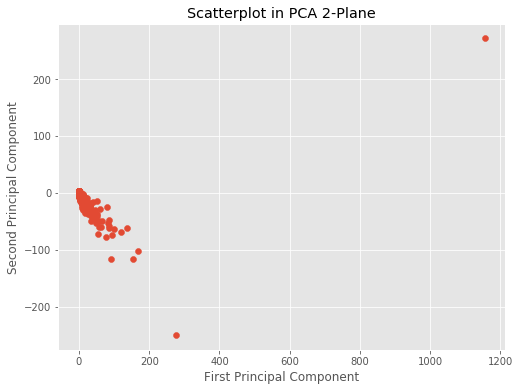

In [12]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(X_reduced[:, 0], X_reduced[:, 1]);
ax.set_title("Scatterplot in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

In [ ]:
X_reduced_df = pd.DataFrame(X_reduced)

In [ ]:
normal_users = X_reduced_df[X_reduced_df.iloc[:,0]<500000][X_reduced_df.iloc[:,1]<200000]

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(normal_users.values[:, 0], normal_users.values[:, 1]);
ax.set_title("Scatterplot in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

It shows that we have some outliers that deviate from the normal users group, which is in accordance with our knowledge of 'super users'.

### 2.3 Seperate outliers from normal users

In [ ]:
# first principal component are mostly composed by below features
minidf.iloc[:,[17, 18,  6, 14,  7]] 

In [ ]:
minidf.iloc[:,[17, 18,  6, 14,  7]].describe()

notice:
- high std
- extreme max values

choose top 20% as outliers group

In [ ]:
quantiles = minidf.iloc[:,[17, 18,  6, 14,  7]].quantile(0.8)

In [ ]:
minidf['outliers?'] = (minidf.iloc[:,7] >= minidf.iloc[:,7].quantile(0.8)) | (minidf.iloc[:,6] >= minidf.iloc[:,6].quantile(0.8)) | (minidf.iloc[:,14] >= minidf.iloc[:,14].quantile(0.8))

In [ ]:
outliers = minidf[minidf['outliers?']]

In [ ]:
outliers.shape[0]/minidf.shape[0]

In [ ]:
churners = outliers[outliers['lifetime_ave_tip_rate'] == 0 ]

In [ ]:
churners[['LIFETIME_ACCOUNT_LOAN_PURCHASE_NUM','LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL','CORE_LOAN_PURCHASE_NUM','CORE_LOAN_PURCHASE_TOTAL','DIRECT_LOAN_PURCHASE_NUM','DIRECT_LOAN_PURCHASE_TOTAL','NUM_TEAM_MEMBERSHIPS']].describe()

In [ ]:
outliers[outliers['lifetime_ave_tip_rate'] == 0 ].T

In [ ]:
pd.scatter_matrix(outliers[['LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL','CORE_LOAN_PURCHASE_TOTAL','LIFETIME_DEPOSIT_TOTAL']],figsize=(10,16));

In [ ]:
minidf[~minidf['outliers?']].shape

In [ ]:
minidf[minidf['outlier?']].CORE_LOAN_PURCHASE_TOTAL

In [ ]:
outliers = minidf[minidf.iloc[:,7] >= minidf.iloc[:,7].quantile(0.8)].shape

In [ ]:
def filter_outliers(df, col_index, pct):
    df['outli'[df.iloc[:,col_index] < df.iloc[:,col_index].quantile(pct)]
    outliers = df[~(df.iloc[:,col_index] < df.iloc[:,col_index].quantile(pct))]
    return df, outliers
    # minidf[minidf.iloc[:,7] < minidf.iloc[:,7].quantile(0.8)]

In [ ]:
minidf.shape

In [ ]:
minidf, outliers = filter_outliers(minidf,7,0.8)

In [ ]:
minidf.shape

In [ ]:
outliers.shape

In [ ]:
minidf.shape[0] + outliers.shape[0]

In [ ]:
filter_outliers(minidf,14,0.8).shape

## 3. Clustering

### 3.1 KMeans ++

In [13]:
from sklearn.cluster import KMeans 

In [ ]:
import scipy.stats as scs

In [14]:
kmeans = KMeans(init='k-means++', n_clusters=15, n_init=10,tol=0.01,verbose=0)

In [15]:
y = kmeans.fit_predict(X_reduced)

In [ ]:
silhouette_score(X_reduced,y)

(-5, 5)

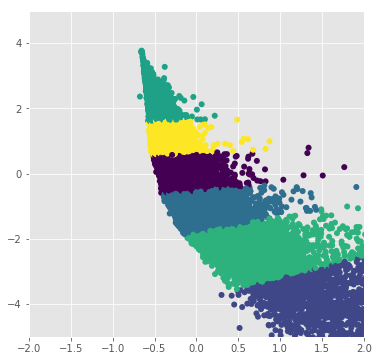

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_reduced[:,0],X_reduced[:,1],c=y,linewidths=0)
ax.set_xlim(-2,2)
ax.set_ylim(-5,5)

In [ ]:
kmeans.cluster_centers_

In [ ]:
majority = X_reduced_df[X_reduced_df.iloc[:,0]<150000][X_reduced_df.iloc[:,1]<50000]

In [ ]:
majority.shape

In [ ]:
y1 = kmeans.fit_predict(majority.values)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(majority.values[:,0],majority.values[:,1],c=y1,linewidths=0)

In [ ]:
X.shape[0] - majority.shape[0] # only 20 outliers lol....

In [ ]:
maj1 = majority[majority.iloc[:,0]<30000][majority.iloc[:,1]<10000] #~120 outliers

In [ ]:
maj1.shape

In [ ]:
ym1 = kmeans.fit_predict(maj1.values)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(maj1.values[:,0],maj1.values[:,1],c=ym1,linewidths=0)
# ax.set_xlim(15000,18000)

In [ ]:
maj1 = majority[majority.iloc[:,0]<30000][majority.iloc[:,1]<10000] #~120 outliers

In [ ]:
maj2 = maj1[maj1.iloc[:,0]<15750][maj1.iloc]

In [ ]:
X.shape[0] - maj2.shape[0] # 311 outliers

In [ ]:
ym2 = kmeans.fit_predict(maj2.values)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(maj2.values[:,0],maj2.values[:,1],c=ym2,linewidths=0);
# ax.set_xlim(15000,18000)

In [ ]:
assigned_cluster = kmeans.transform(maj2.values).argmin(axis=1)

In [ ]:
maj2['cluster'] = assigned_cluster

In [ ]:
maj2[maj2['cluster'] == 0].shape

In [ ]:
maj2[maj2['cluster'] == 1].shape

In [ ]:
maj3 = maj2[maj2['cluster'] == 0]

In [ ]:
ym3 = kmeans.fit_predict(maj3.values)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(maj3.values[:,0],maj3.values[:,1],c=ym3,linewidths=0);

**convert back cluster number**

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=20, n_init=10,tol=0.01,verbose=0)
y = kmeans.fit_predict(X_reduced)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_reduced[:,0],X_reduced[:,1],c=y,linewidths=0)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_reduced[:,0],X_reduced[:,1],c=y,linewidths=0)
ax.set_xlim(-5,200)
ax.set_ylim(-110,10)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_reduced[:,0],X_reduced[:,1],c=y,linewidths=0)
ax.set_xlim(-5,25)
ax.set_ylim(-40,10)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_reduced[:,0],X_reduced[:,1],c=y,linewidths=0)
ax.set_xlim(-2,5)
ax.set_ylim(-20,5)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_reduced[:,0],X_reduced[:,1],c=y,linewidths=0)
ax.set_xlim(-1,1)
ax.set_ylim(-5,5)

In [ ]:
assigned_cluster = kmeans.transform(X_reduced).argmin(axis=1)

In [ ]:
assigned_cluster

In [ ]:
X_reduced_df['cluster'] = assigned_cluster

In [ ]:
X_reduced_df.groupby('cluster').agg({0:['mean','count'],1:'mean'})

In [ ]:
ls['cluster'] = X_reduced_df['cluster']

In [ ]:
ls.head()

In [ ]:
for i in list(ls[ls['cluster'] == 1].columns):
    print(i, ls.loc[27627,i])

In [ ]:
cluster14.describe().loc[['mean','min','25%','50%','75%','max'],:].T

In [ ]:
cluster14[['LIFETIME_DEPOSIT_TOTAL',]]

#### 3.1.2 choosing k

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [ ]:
import itertools

In [ ]:
x = X_reduced

In [ ]:
silhouette_score(x,y)

In [ ]:
maxk = 8
wcss = np.zeros(maxk)
silhouette = np.zeros(maxk)

fig, axes = plt.subplots(3, 4, figsize=(16,9))

# flatten
axes = [ax for axrow in axes for ax in axrow]

for k, ax in zip(range(1,maxk), axes):
    km = KMeans(k)
    y = km.fit_predict(x)
    ax.axis('off')
    ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    ax.set_ylim(ymin=-9, ymax=8)
    
    
    for c in range(0, k):
        for i1, i2 in itertools.combinations([ i for i in range(len(y)) if y[i] == c ], 2):
            wcss[k] += sum(x[i1] - x[i2])**2
    wcss[k] /= 2
    
    if k > 1:
        silhouette[k] = silhouette_score(x,y)

1. FE - non linear relationships - PCA can reduce linear combinations
2. cluster on a few features first - business intuition
3. can I use Gini Punity -- if I can create labels? (e.g. donations)

### 3.2 HCA

In [ ]:
def make_dendrogram(dataframe, linkage_method, metric, color_threshold=None):
    '''
    This function creates and plots the dendrogram created by hierarchical clustering.
    
    INPUTS: Pandas Dataframe, string, string, int
    
    OUTPUTS: None
    '''
    distxy = squareform(pdist(dataframe.values, metric=metric))
    Z = linkage(distxy, linkage_method)
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=12.,  # font size for the x axis labels
        labels = dataframe.index,
        color_threshold = color_threshold
    )
    plt.show()

### 3.3 NMF